# High pass filtering with scipy

Okay, let's revisit the same problem as before, but now we'll attempt to solve this using routines in scipy. The fundamentals, and internals, of what scipy is doing is the same as what we've just covered, but it will do it better (and probably faster). However, it is important that you are not only able to run libraries like numpy/scipy but also have some understanding of what they're doing (and why).

Let's begin by once again creating the data

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal

In [2]:
# Sorry, this won't work for you! Please replace with the functions you wrote last week!

from fourier_transform import compute_fourier_transform, compute_inverse_fourier_transform


In [3]:
# Choose data length and sampling rate
omega = 1. * (2*np.pi)
data_length = 1024
sample_rate = 16
sample_points = int(data_length * sample_rate)

times = np.arange(sample_points) / sample_rate
frequencies = np.arange(sample_points) / data_length
np.random.seed(0)
data_time_domain = np.zeros(sample_points)
# Add low frequency noise: No components above 1Hz
for i in range(1,(data_length) + 1):
    # We generate a random number between 0 and 1 for the frequency,
    # This means it won't line up perfectly with the
    omega = np.random.uniform() * (2*np.pi)
    # randomly set the phase, so that it isn't all in the
    # imaginary frequency component!
    phase = np.random.random() * (2*np.pi)
    data_time_domain += 100 * np.sin(times * omega + phase)

# Add in a single 4Hz sine wave - random phase again
omega = 4. * (2*np.pi)
phase = np.random.random() * 2 * np.pi
signal = np.cos(times * omega + phase)
data_time_domain += signal

data_length_short = 8
data_time_domain_CUT = data_time_domain[504*sample_rate:(504+data_length_short)*sample_rate]
frequencies_cut = np.arange(data_length_short * sample_rate) / data_length_short
times_cut = np.arange(data_length_short * sample_rate) / sample_rate
signal_CUT = signal[504*sample_rate:(504+data_length_short)*sample_rate]

Here's an example of using scipy to perform a high-pass filter of this data

Text(0.5, 0, 'Times (s)')

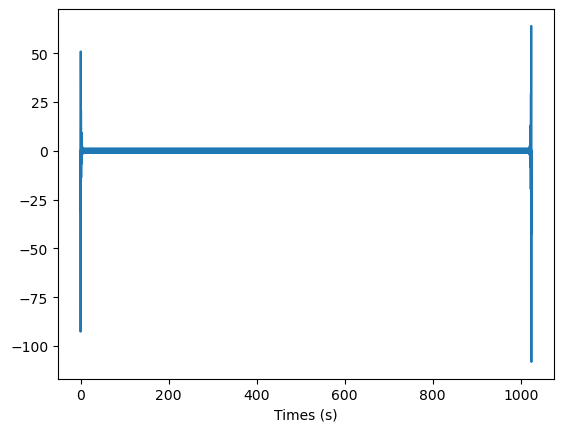

In [4]:
import scipy.signal
# As with many things in python, good examples always exist on places like stackoverflow. It is not wrong to use
# these, but you should credit where they come from.

# https://dsp.stackexchange.com/questions/41184/high-pass-filter-in-python-scipy
def highpass_filter_scipy(data, sample_rate):
    # As we saw above, our filter cannot be an abrupt cut off. Here we say that no frequency content below 1Hz will
    # be passed, and all frequency content above 1.5Hz will be passed. Between there some content will be passed.
    filter_stop_freq = 1 # Hz
    filter_pass_freq = 1.5  # Hz
    # The filter order is how long (in samples) the filter will be. We used 256 before, so use it again here.
    # However, due to symmetry, we enter (256 / 2) + 1
    filter_order = 129

    # High-pass filter
    nyquist_rate = sample_rate / 2.
    desired = (0, 0, 1, 1)
    bands = (0, filter_stop_freq, filter_pass_freq, nyquist_rate)
    filter_coefs = scipy.signal.firls(filter_order, bands, desired, fs=nyquist_rate  *2)

    # Apply high-pass filter
    filtered_data = scipy.signal.filtfilt(filter_coefs, [1], data)
    return filtered_data

# Use scipy to high-pass filter the data
data_time_domain_scipy_passed = highpass_filter_scipy(data_time_domain, sample_rate)
plt.figure()
plt.plot(times, data_time_domain_scipy_passed)
plt.xlabel("Times (s)")


WAIT!! That looks rubbish. The high-pass filter will "corrupt" data at the start and the end. This corruption corresponds to the length of the filter in the time-domain. This was present in the previous notebook as well, after applying the convolution the data length was *shorter* by 16 seconds. We could have produced this corrupted region if we wanted to. We do need to remove this corrupted region.

We specified the length (read the comments) of the scipy filter in the function above, so we remove 8 seconds at the start and end to correct for this.

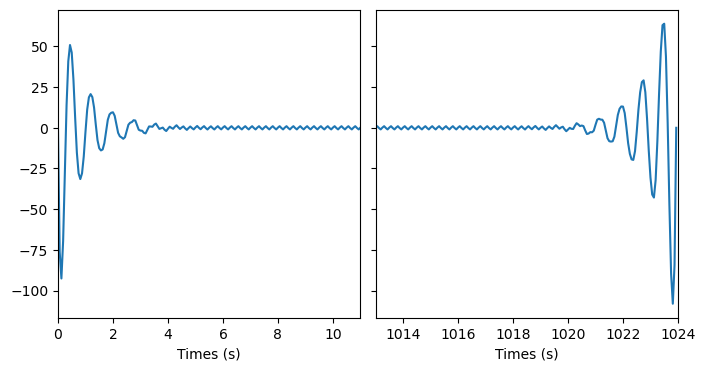

In [15]:
# Let's zoom in on the start/end of the processed data to begin with
fig, axes = plt.subplots(1,2, figsize=(8,4), sharey='row')
axes[0].plot(times, data_time_domain_scipy_passed)
axes[0].set_xlim(0, 11)
axes[1].plot(times, data_time_domain_scipy_passed)
axes[1].set_xlim(1013, 1024)
axes[0].set_xlabel("Times (s)")
axes[1].set_xlabel("Times (s)")
fig.subplots_adjust(wspace=0.05)

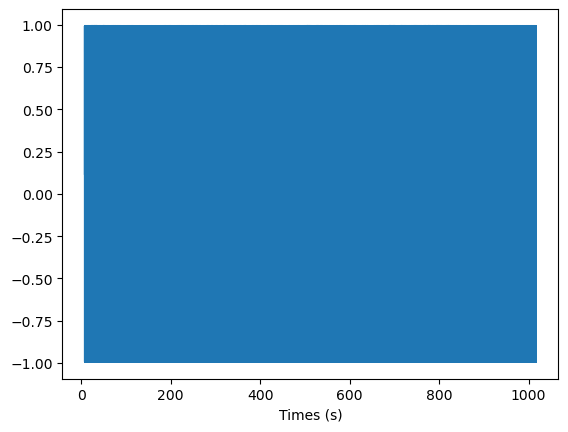

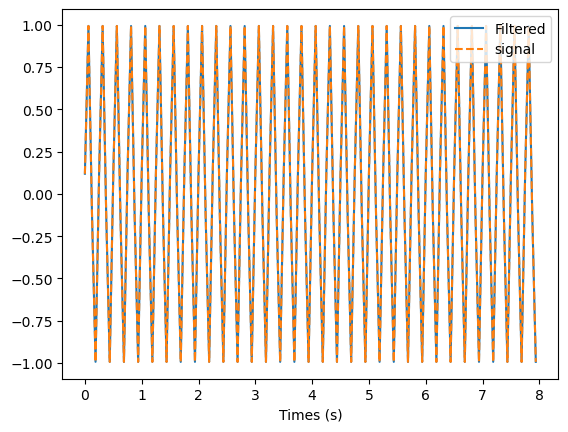

In [5]:
data_time_domain_scipy_passed_lop = data_time_domain_scipy_passed[8*sample_rate:-(sample_rate*8)]
# And a representative 8s chunk
data_time_domain_scipy_passed_CUT = data_time_domain_scipy_passed_lop[504*sample_rate:504*sample_rate+len(times_cut)]

plt.figure()
plt.plot(times[8*sample_rate:-(sample_rate*8)], data_time_domain_scipy_passed_lop)
plt.xlabel("Times (s)")

plt.figure()
plt.plot(times_cut, data_time_domain_scipy_passed_CUT, label='Filtered')
plt.plot(times_cut, signal_CUT, label='signal', linestyle='--')
plt.xlabel("Times (s)")
plt.legend()


And then plotted in the frequency domain, this looks great!

Text(0, 0.5, 'Amplitude')

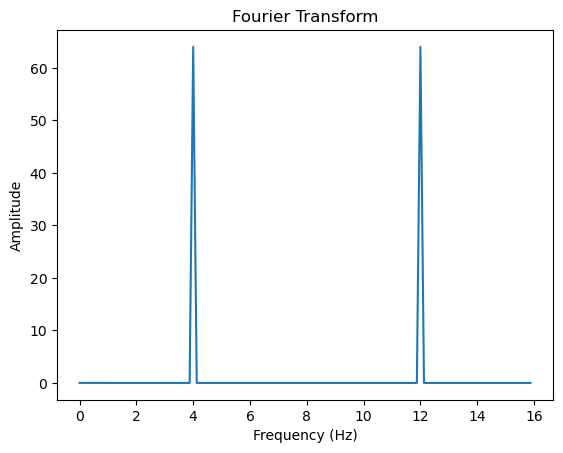

In [6]:
# This second one looks great

plt.figure()
data_frequency_domain = compute_fourier_transform(data_time_domain_scipy_passed_CUT)
plt.plot(frequencies_cut, abs(data_frequency_domain))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
